# Expected profit analysis - Impact of key paramaters

#### Maria Silva, September 2024

## Import packages

In [1]:
import os
import copy
import itertools
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
from rollup import RollupSpec
from extraction import compute_expected_profit_diff

## General settings

In [4]:
# plotly template
paper_template = dict(
    layout=go.Layout(
        template="simple_white",
        font=dict(size=14, family="Clear Sans"),
        margin=go.layout.Margin(
            l=40,  # left margin
            r=40,  # right margin
            b=40,  # bottom margin
            t=80,  # top margin
        ),
        width=550,
        height=500,
        xaxis=dict(
            automargin=True, minor_ticks="inside", showgrid=True, griddash="dash", minor_griddash="dot"
        ),
        yaxis=dict(
            automargin=True, minor_ticks="inside", showgrid=True, griddash="dash", minor_griddash="dot"
        ),
        )
)

In [5]:
# arb target pool settings
arb_pool_fee = 0.0005 # must be same for both rollups
arb_pool_reserve_y = 100_000.0 # assuming same for both rollups
arb_price_diff = 0.01 # i.e. (P_A - P_B) / P_B
price_B = 1.0 # this is the price of token X as a unit of token Y in rollup B
price_A = price_B * (1 + arb_price_diff)

# Init spec classes - rollup A
rollup_A = RollupSpec(
    fail_rate=0.0,
    arb_pool_reserve_x=arb_pool_reserve_y/price_A,
    arb_pool_reserve_y=arb_pool_reserve_y,
    arb_pool_fee=arb_pool_fee,
)
# Init spec classes  - rollup B
rollup_B = RollupSpec(
    fail_rate=0.0,
    arb_pool_reserve_x=arb_pool_reserve_y/price_B,
    arb_pool_reserve_y=arb_pool_reserve_y,
    arb_pool_fee=arb_pool_fee,
)

In [6]:
# matrix grid of failure rates
fail_rate_A_arr = np.arange(0,1.1,0.1)
fail_rate_B_arr = np.arange(0,1.1,0.1)
fail_grid_list = list(itertools.product(fail_rate_A_arr, fail_rate_B_arr))

## Analysis 1 - external price is in the middle

In [7]:
# Define external price -> external price is a middle point between P_A and P_B
external_price = price_B + (price_A-price_B)/2
print("price_A: ", price_A, ", price_B: ", price_B, ", external_price: ", external_price)

# For each fail rate pair, compute profit diffs
middle_price_results_df = pd.DataFrame()
for i_fail_rate_A, i_fail_rate_B in fail_grid_list:
    # redefine fail rates
    i_rollup_A = copy.deepcopy(rollup_A)
    i_rollup_A.fail_rate = i_fail_rate_A
    i_rollup_B = copy.deepcopy(rollup_B)
    i_rollup_B.fail_rate = i_fail_rate_B
    # compute profit diff
    i_profit_diff = compute_expected_profit_diff(i_rollup_A, i_rollup_B, external_price) 
    # store data
    i_results_df = pd.DataFrame({
        "fail_rate_A": [i_fail_rate_A],
        "fail_rate_B": [i_fail_rate_B],
        "profit_diff": [i_profit_diff],
    })
    middle_price_results_df = pd.concat([middle_price_results_df, i_results_df])

middle_price_results_df.head()

price_A:  1.01 , price_B:  1.0 , external_price:  1.005


,fail_rate_A,fail_rate_B,profit_diff
0,0.0,0.0,0.000000
0,0.0,0.1,-0.048977
0,0.0,0.2,-0.097955
0,0.0,0.3,-0.146932
0,0.0,0.4,-0.195909


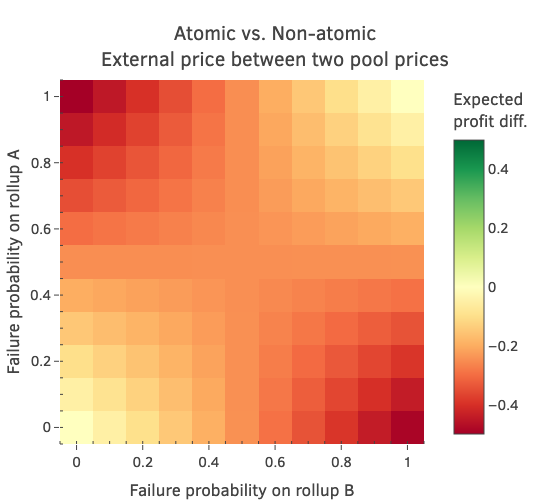

In [8]:
middle_price_pivot_df = middle_price_results_df.pivot(index='fail_rate_A', columns='fail_rate_B', values='profit_diff')
fig = px.imshow(middle_price_pivot_df, template=paper_template, color_continuous_midpoint=0,
                color_continuous_scale=px.colors.colorbrewer.RdYlGn, origin='lower')
fig.update_layout(xaxis_title="Failure probability on rollup B", 
                  yaxis_title="Failure probability on rollup A",
                  title="Atomic vs. Non-atomic<br>External price between two pool prices",
                  coloraxis_colorbar=dict(title="Expected<br>profit diff."),
                  )
pio.write_image(fig, '../figures/middle_price_heatmap.png', scale=4)
fig.show('png')

## Analysis 2 - external price is smaller

In [9]:
# Define external price -> external price is lower than P_B
external_price = price_B/(1 + arb_price_diff)
print("price_A: ", price_A, ", price_B: ", price_B, ", external_price: ", external_price)

# For each fail rate pair, compute profit diffs
low_price_results_df = pd.DataFrame()
for i_fail_rate_A, i_fail_rate_B in fail_grid_list:
    # redefine fail rates
    i_rollup_A = copy.deepcopy(rollup_A)
    i_rollup_A.fail_rate = i_fail_rate_A
    i_rollup_B = copy.deepcopy(rollup_B)
    i_rollup_B.fail_rate = i_fail_rate_B
    # compute profit diff
    i_profit_diff = compute_expected_profit_diff(i_rollup_A, i_rollup_B, external_price) 
    # store data
    i_results_df = pd.DataFrame({
        "fail_rate_A": [i_fail_rate_A],
        "fail_rate_B": [i_fail_rate_B],
        "profit_diff": [i_profit_diff],
    })
    low_price_results_df = pd.concat([low_price_results_df, i_results_df])

low_price_results_df.head()

price_A:  1.01 , price_B:  1.0 , external_price:  0.9900990099009901


,fail_rate_A,fail_rate_B,profit_diff
0,0.0,0.0,0.000000
0,0.0,0.1,-0.417904
0,0.0,0.2,-0.835808
0,0.0,0.3,-1.253712
0,0.0,0.4,-1.671615


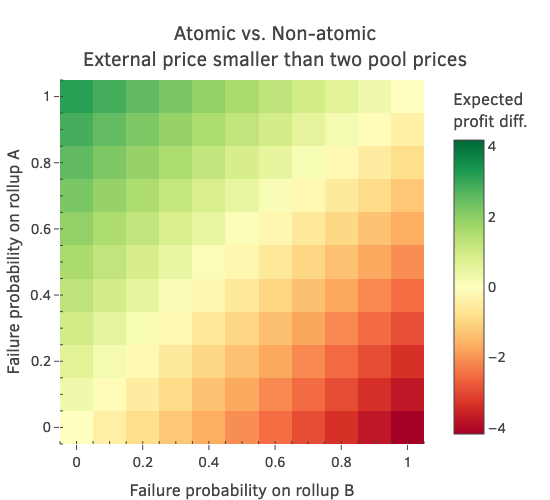

In [10]:
low_price_pivot_df = low_price_results_df.pivot(index='fail_rate_A', columns='fail_rate_B', values='profit_diff')
fig = px.imshow(low_price_pivot_df, template=paper_template, color_continuous_midpoint=0,
                color_continuous_scale=px.colors.colorbrewer.RdYlGn, origin='lower')
fig.update_layout(xaxis_title="Failure probability on rollup B", 
                  yaxis_title="Failure probability on rollup A",
                  title="Atomic vs. Non-atomic<br>External price smaller than two pool prices",
                  coloraxis_colorbar=dict(title="Expected<br>profit diff."),
                  )
pio.write_image(fig, '../figures/low_price_heatmap.png', scale=4)
fig.show('png')

## Analysis 3 - external price is larger

In [11]:
# Define external price -> external price is lower than P_A
external_price = price_A*(1 + arb_price_diff)
print("price_A: ", price_A, ", price_B: ", price_B, ", external_price: ", external_price)

# For each fail rate pair, compute profit diffs
high_price_results_df = pd.DataFrame()
for i_fail_rate_A, i_fail_rate_B in fail_grid_list:
    # redefine fail rates
    i_rollup_A = copy.deepcopy(rollup_A)
    i_rollup_A.fail_rate = i_fail_rate_A
    i_rollup_B = copy.deepcopy(rollup_B)
    i_rollup_B.fail_rate = i_fail_rate_B
    # compute profit diff
    i_profit_diff = compute_expected_profit_diff(i_rollup_A, i_rollup_B, external_price) 
    # store data
    i_results_df = pd.DataFrame({
        "fail_rate_A": [i_fail_rate_A],
        "fail_rate_B": [i_fail_rate_B],
        "profit_diff": [i_profit_diff],
    })
    high_price_results_df = pd.concat([high_price_results_df, i_results_df])

high_price_results_df.head()

price_A:  1.01 , price_B:  1.0 , external_price:  1.0201


,fail_rate_A,fail_rate_B,profit_diff
0,0.0,0.0,0.000000
0,0.0,0.1,0.324876
0,0.0,0.2,0.649753
0,0.0,0.3,0.974629
0,0.0,0.4,1.299506


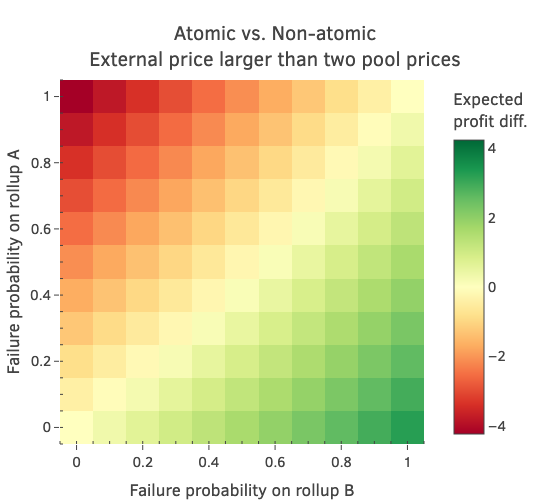

In [12]:
high_price_pivot_df = high_price_results_df.pivot(index='fail_rate_A', columns='fail_rate_B', values='profit_diff')
fig = px.imshow(high_price_pivot_df, template=paper_template, color_continuous_midpoint=0,
                color_continuous_scale=px.colors.colorbrewer.RdYlGn, origin='lower')
fig.update_layout(xaxis_title="Failure probability on rollup B", 
                  yaxis_title="Failure probability on rollup A",
                  title="Atomic vs. Non-atomic<br>External price larger than two pool prices",
                  coloraxis_colorbar=dict(title="Expected<br>profit diff."),
                  )
pio.write_image(fig, '../figures/high_price_heatmap.png', scale=4)
fig.show('png')